General optimizations:
- Diro2C generation algorithm could take into account possible values for categorical features or integer features
- scikit-learn Decision tree implementation does not support categorical values, they are currently only approximated by converting them to numbers. Look into alternative implementations or encode values
- it would be better for the understanding, to see how rules evolve with increasing max depth. I used unix diff for that
- general rule for determining, how far to increase max depth parameter

In [17]:
import matplotlib.pyplot as plt
import pickle
import numpy as np
import pandas as pd
from comparers import ModelComparer, plot_decision_boundary
from diro2c_wrapper import WrappedDiro2C, train_surrogate_tree, plot_surrogate_tree,\
                           extract_rules, print_rules, evaluate_generated_data,\
                           evaluate, plot_tree_leafs_2d, plot_diro2c_2d, get_surrogate_tree,\
                           get_feature_importances, plot_feature_importances, set_generated_data,\
                           search_max_depth_parameter
from util import RuleClassifier, evaluate_counterfactual_fidelity, get_complexity, constraint_matrix_to_rules
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import os
from datetime import datetime

In [2]:
with open('task_without_noise.pickle', 'rb') as f:
    clf_a, clf_b, X, X_display, y, feature_names, categorical_features, feature_precisions = pickle.load(f)

In [3]:
comparer = ModelComparer(clf_a, clf_b, feature_names)

# Explanations

In [4]:
mclass_diff = comparer.predict_mclass_diff(X)

In [86]:
global_fidelities = {}
local_fidelities = {}
complexities = {}

## $(False, True)$

In [6]:
focus_class = '(False, True)'
focus_class_idx = list(comparer.class_names).index(focus_class)
y_true = mclass_diff == focus_class_idx

In [7]:
explainer = WrappedDiro2C(X, comparer, focus_class)

Let's first check how long it takes to generate a data set for a single instance:

In [13]:
%%time
_ = explainer.generate_local_explanation(idx_explain=0)

CPU times: user 11min 29s, sys: 37.7 s, total: 12min 7s
Wall time: 3min 31s


In [14]:
((3*60 + 31) * len(X))/60/60

57.26305555555555

In [11]:
%%time
_ = explainer.generate_local_explanation(idx_explain=0, gn_population_size=500)

CPU times: user 1min 6s, sys: 4.77 s, total: 1min 11s
Wall time: 21 s


In [12]:
(21 * len(X))/60/60

5.699166666666667

Even with a reduced population size parameter it still would take more than 5 hours to generate data sets for all instances. I'll use a different approach, where the final data set is built from the merged generated data sets created for only the instances classified differently, but with the default population size parameter. This way, I expect the algorithm to generate instances near to the already known differences.

In [9]:
instance_indices = np.arange(len(X))

In [14]:
try:
    os.mkdir('diro2c-datasets')
except FileExistsError:
    pass

In [22]:
%%time
started = datetime.now()
for instance_idx in instance_indices:
    print(str(instance_idx), end='... ')
    explanation = explainer.generate_local_explanation(instance_idx)
    with open(f'./diro2c-datasets/{focus_class}.{instance_idx}.pickle', 'wb') as f:
        pickle.dump(explanation, f)
    print(datetime.now() - started)

0... 0:03:33.349520
1... 0:07:18.898019
2... 0:11:09.452534
3... 0:15:04.549423
4... 0:18:55.328720
5... 0:22:33.628496
6... 0:26:30.837308
7... 0:30:14.146966
8... 0:33:38.735274
9... 0:37:03.115946
10... 0:40:23.465602
11... 0:43:47.299845
12... 0:47:12.685789
13... 0:50:41.682704
14... 0:54:10.193997
15... 0:57:34.932407
16... 1:01:02.576799
17... 1:04:30.016211
18... 1:07:57.764176
19... 1:11:23.972110
20... 1:14:57.362369
21... 1:18:45.840911
22... 1:22:50.108421
23... 1:26:36.614533
24... 1:30:26.144743
25... 1:34:21.132817
26... 1:38:06.270724
27... 1:42:04.179484
28... 1:45:58.523548
29... 1:50:02.230184
30... 1:54:37.003711
31... 1:58:31.307680
32... 2:02:10.284902
33... 2:06:19.751943
34... 2:10:18.823240
35... 2:14:04.913860
36... 2:17:58.149432
37... 2:21:53.375469
38... 2:25:37.961293
39... 2:29:25.738737
40... 2:34:03.230550
41... 2:37:54.577780
42... 2:41:16.038997
43... 2:44:37.820869
44... 2:47:58.353511
45... 2:51:18.055754
46... 2:54:38.453437
47... 2:57:59.278634
48

KeyboardInterrupt: 

In [24]:
explanations = []
for instance_idx in instance_indices:
    with open(f'./diro2c-datasets/{focus_class}.{instance_idx}.pickle', 'rb') as f:
        explanation = pickle.load(f)
    explanations.append(explanation)

In [25]:
with open(f'ground_truth.{focus_class}.pickle', 'rb') as f:
    ground_truth_instance_indices, ground_truth = pickle.load(f)

In [26]:
X_explain = np.concatenate([explanation['binary_diff_classifer']['evaluation_info']['X']
                            for explanation in explanations])
y_explain = np.concatenate([explanation['binary_diff_classifer']['evaluation_info']['y']
                            for explanation in explanations])

In [130]:
len(X_explain)

1023461

In [27]:
explanation = explanations[0]
set_generated_data(explanation, X_explain, y_explain)

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption


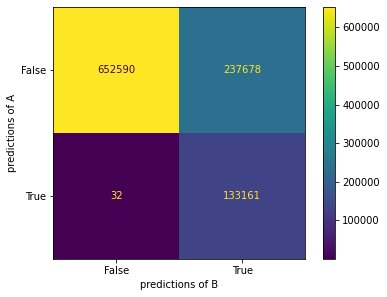

In [29]:
comparer.plot_confusion_matrix(X_explain)
plt.savefig('adult-cf-diro2c.pdf')

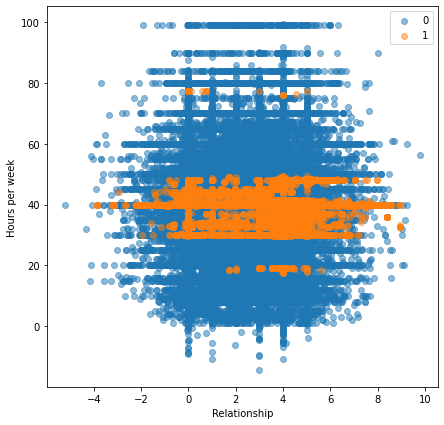

In [30]:
plot_diro2c_2d(explanation, 'Relationship', 'Hours per week')

### Find Optimal Solution

In [31]:
%%time
metrics = search_max_depth_parameter(explanation, X, y_true=y_true, start=2, stop=20)

CPU times: user 2min 40s, sys: 1.52 s, total: 2min 42s
Wall time: 2min 52s


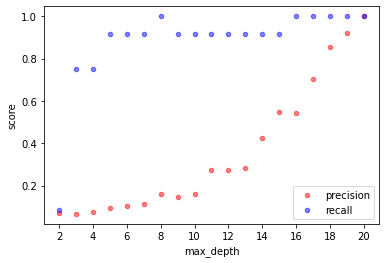

In [129]:
df = metrics.reset_index()
ax = df.plot(kind='scatter', x='index', y='precision', label='precision', color='r', alpha=0.5)
df.plot(kind='scatter', x='index', y='recall', label='recall', color='b', alpha=0.5, ax=ax)
plt.xlabel('max_depth')
plt.ylabel('score')
plt.xticks([i for i in range(1, 21) if i%2 != 1])
plt.savefig('adult-diro2c-pr-curve.pdf')

- setting 4 has 75\% recall and a slightly better precision than setting 3, although not perfect it will serve as the global explanation
- setting 8 is the lowest where recall is perfect. it will serve as the local explanations
- setting 16 has perfect recall and a precision of over 50\%
- setting 20 has both recall and precision perfect

In [36]:
metrics

,precision,recall,rules,constraints
2,0.071429,0.083333,1,2
3,0.066176,0.750000,2,6
4,0.076923,0.750000,2,8
5,0.095652,0.916667,3,15
6,0.101852,0.916667,3,18
7,0.114583,0.916667,3,20
8,0.160000,1.000000,4,29
9,0.148649,0.916667,4,33
10,0.161765,0.916667,4,35
11,0.275000,0.916667,4,36


### Tree with depth 4 (Global Explanation)

In [87]:
%%time
max_depth = 4
train_surrogate_tree(explanation, max_depth=max_depth)

CPU times: user 2.27 s, sys: 64.6 ms, total: 2.33 s
Wall time: 2.42 s


In [88]:
evaluate_generated_data(explanation)

              precision    recall  f1-score   support

           0       0.95      0.87      0.91    785783
           1       0.67      0.85      0.75    237678

    accuracy                           0.87   1023461
   macro avg       0.81      0.86      0.83   1023461
weighted avg       0.89      0.87      0.87   1023461



In [89]:
evaluate(explanation, X, y_true);

              precision    recall  f1-score   support

           0       1.00      0.88      0.94       965
           1       0.07      0.75      0.14        12

    accuracy                           0.88       977
   macro avg       0.54      0.82      0.54       977
weighted avg       0.99      0.88      0.93       977



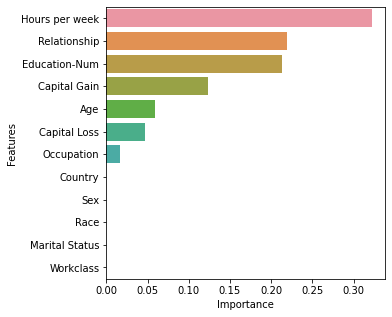

In [90]:
feature_importances, feature_order = get_feature_importances(explanation)
plot_feature_importances(explanation, feature_importances, feature_order, figsize=(5, 5))

In [91]:
y = (y_true).astype(int)
constraints, rules, class_occurences, instance_indices_per_rule = extract_rules(explanation, X, y)
len(rules)

4

In [92]:
indices = np.where(y_true)[0]
pred_rules = pd.Series(RuleClassifier(feature_names, rules).apply(X[indices]), index=indices)
pred_rules

64     1
70     1
406    1
484    0
531    3
558    0
701    1
744    0
883    1
925    1
948    1
961    1
dtype: int64

In [93]:
constraints, rules, class_occurences, instance_indices_per_rule = \
    zip(*[el for i, el in enumerate(zip(constraints, rules, class_occurences, instance_indices_per_rule), 1)
           if i in np.unique(pred_rules)])

In [102]:
rules = constraint_matrix_to_rules(constraints, feature_names, feature_order, feature_precisions, latex=True)
for rule, class_occurences in zip(rules, class_occurences):
    print(f'\item ${rule}$ {class_occurences.astype(int).tolist()}')

\item $30 < \mathit{Hoursperweek} \leq 41 \land \mathit{Relationship} > 3 \land \mathit{EducationNum} > 9$ [91662, 166008]
\item $\mathit{Hoursperweek} > 39 \land \mathit{Relationship} \leq 3 \land \mathit{EducationNum} > 15 \land \mathit{CapitalGain} \leq 5121$ [4016, 9217]


#### Evaluation

##### Global Fidelity

In [103]:
global_fidelities[(max_depth, focus_class)] = evaluate(explanation, X, y_true)

              precision    recall  f1-score   support

           0       1.00      0.88      0.94       965
           1       0.07      0.75      0.14        12

    accuracy                           0.88       977
   macro avg       0.54      0.82      0.54       977
weighted avg       0.99      0.88      0.93       977



##### Counterfactual Fidelity Error

In [104]:
errors, statistics = evaluate_counterfactual_fidelity(comparer, ground_truth_instance_indices,
                                                      ground_truth, instance_indices_per_rule,
                                                      constraints)

invalid value encountered in true_divide


In [105]:
local_fidelities[(max_depth, focus_class)] = statistics
statistics

,RMSE,BMR,BAR
Age,NaN,1.000000,NaN
Workclass,NaN,1.000000,NaN
Education-Num,1.827362,0.470588,0.0
Marital Status,NaN,1.000000,NaN
Occupation,NaN,1.000000,NaN
Relationship,1.157557,0.357143,0.0
Race,NaN,1.000000,NaN
Sex,NaN,1.000000,NaN
Capital Gain,5064.550049,0.888889,0.0
Capital Loss,NaN,1.000000,NaN


##### Complexity

In [106]:
res = get_complexity(constraints)
complexities[(max_depth, focus_class)] = res
res

Rules          2
Constraints    8
dtype: int64

### Tree with depth 8

In [107]:
%%time
max_depth = 8
train_surrogate_tree(explanation, max_depth=max_depth)

CPU times: user 4.16 s, sys: 76.7 ms, total: 4.23 s
Wall time: 4.43 s


In [108]:
evaluate_generated_data(explanation)

              precision    recall  f1-score   support

           0       0.98      0.90      0.94    785783
           1       0.74      0.95      0.83    237678

    accuracy                           0.91   1023461
   macro avg       0.86      0.92      0.88   1023461
weighted avg       0.93      0.91      0.91   1023461



In [109]:
evaluate(explanation, X, y_true);

              precision    recall  f1-score   support

           0       1.00      0.91      0.95       965
           1       0.12      1.00      0.22        12

    accuracy                           0.91       977
   macro avg       0.56      0.96      0.59       977
weighted avg       0.99      0.91      0.94       977



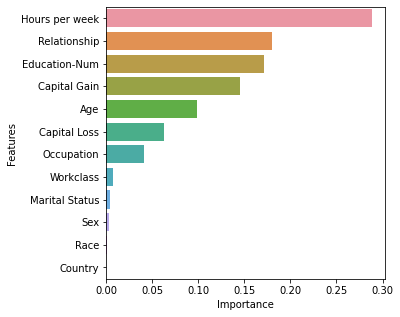

In [110]:
feature_importances, feature_order = get_feature_importances(explanation)
plot_feature_importances(explanation, feature_importances, feature_order, figsize=(5, 5))

In [111]:
y = (y_true).astype(int)
constraints, rules, class_occurences, instance_indices_per_rule = extract_rules(explanation, X, y)
len(rules)

75

In [112]:
indices = np.where(y_true)[0]
pred_rules = pd.Series(RuleClassifier(feature_names, rules).apply(X[indices]), index=indices)
pred_rules

64     1
70     1
406    1
484    4
531    5
558    8
701    1
744    4
883    1
925    1
948    1
961    1
dtype: int64

In [113]:
constraints, rules, class_occurences, instance_indices_per_rule = \
    zip(*[el for i, el in enumerate(zip(constraints, rules, class_occurences, instance_indices_per_rule), 1)
           if i in np.unique(pred_rules)])

In [114]:
rules = constraint_matrix_to_rules(constraints, feature_names, feature_order, feature_precisions, latex=True)
for rule, class_occurences in zip(rules, class_occurences):
    print(f'\item ${rule}$ {class_occurences.astype(int).tolist()}')

\item $39 < \mathit{Hoursperweek} \leq 41 \land \mathit{Relationship} > 3 \land \mathit{EducationNum} > 9 \land \mathit{CapitalGain} \leq 6703 \land \mathit{Age} > 27 \land \mathit{CapitalLoss} \leq 1568$ [52709, 139421]
\item $36 < \mathit{Hoursperweek} \leq 41 \land \mathit{Relationship} > 3 \land \mathit{EducationNum} \leq 9 \land \mathit{Age} > 41 \land 4 < \mathit{Occupation} \leq 5 \land \mathit{Workclass} \leq 6$ [1337, 10364]
\item $39 < \mathit{Hoursperweek} \leq 48 \land \mathit{Relationship} \leq 3 \land \mathit{EducationNum} > 15 \land \mathit{CapitalGain} \leq 3 \land \mathit{Age} > 34 \land \mathit{Sex} > 1$ [666, 8001]
\item $34 < \mathit{Hoursperweek} \leq 44 \land \mathit{Relationship} \leq 3 \land \mathit{EducationNum} > 12 \land 5121 < \mathit{CapitalGain} \leq 10535 \land \mathit{Age} > 21$ [1567, 2708]


#### Evaluation

##### Global Fidelity

In [115]:
global_fidelities[(max_depth, focus_class)] = evaluate(explanation, X, y_true)

              precision    recall  f1-score   support

           0       1.00      0.91      0.95       965
           1       0.12      1.00      0.22        12

    accuracy                           0.91       977
   macro avg       0.56      0.96      0.59       977
weighted avg       0.99      0.91      0.94       977



##### Counterfactual Fidelity Error

In [116]:
errors, statistics = evaluate_counterfactual_fidelity(comparer, ground_truth_instance_indices,
                                                      ground_truth, instance_indices_per_rule,
                                                      constraints)

invalid value encountered in true_divide


In [117]:
local_fidelities[(max_depth, focus_class)] = statistics
statistics

,RMSE,BMR,BAR
Age,13.599005,0.500000,0.0
Workclass,0.753305,0.904762,0.0
Education-Num,1.611775,0.478261,0.0
Marital Status,NaN,1.000000,NaN
Occupation,0.525991,0.826087,0.0
Relationship,1.014025,0.368421,0.0
Race,NaN,1.000000,NaN
Sex,0.505911,0.900000,0.0
Capital Gain,5777.988874,0.153846,0.0
Capital Loss,727.338724,0.333333,0.0


##### Complexity

In [118]:
res = get_complexity(constraints)
complexities[(max_depth, focus_class)] = res
res

Rules           4
Constraints    29
dtype: int64

# Summary

In [119]:
def map_index(index):
    class_, depth = index[0], index[1]
    if depth == 4:
        level = 'global'
    elif depth == 8:
        level = 'local'
    else:
        level = None
    return (class_, level) if len(index) == 2 else (class_, level, index[2])

## Global Fidelity

In [120]:
global_fidelity = pd.concat(global_fidelities.values(), keys=global_fidelities.keys(), names=('depth', 'class'))
global_fidelity = global_fidelity[global_fidelity.index.get_level_values(2).astype(int) == 1]
global_fidelity.index = global_fidelity.index.droplevel(2)
global_fidelity = global_fidelity.reorder_levels(['class', 'depth']).sort_index()
global_fidelity

Precision  Recall  F1 Score  Support
class         depth                                      
(False, True) 4       0.074380    0.75  0.135338       12
              8       0.122449    1.00  0.218182       12

## Local Fidelity

In [121]:
local_fidelity = pd.concat(local_fidelities.values(), keys=local_fidelities.keys(), names=('depth', 'class', 'feature'))
local_fidelity = local_fidelity.reorder_levels(['class', 'depth', 'feature']).sort_index()
local_fidelity

RMSE       BMR  BAR
class         depth feature                                   
(False, True) 4     Age                     NaN  1.000000  NaN
                    Capital Gain    5064.550049  0.888889  0.0
                    Capital Loss            NaN  1.000000  NaN
                    Country                 NaN  1.000000  NaN
                    Education-Num      1.827362  0.470588  0.0
                    Hours per week     6.516664  0.055556  0.0
                    Marital Status          NaN  1.000000  NaN
                    Occupation              NaN  1.000000  NaN
                    Race                    NaN  1.000000  NaN
                    Relationship       1.157557  0.357143  0.0
                    Sex                     NaN  1.000000  NaN
                    Workclass               NaN  1.000000  NaN
              8     Age               13.599005  0.500000  0.0
                    Capital Gain    5777.988874  0.153846  0.0
                    Capital Loss     727.338724  0.333333  0.0
                    Country                 NaN  1.000000  NaN
                    Education-Num      1.611775  0.478261  0.0
                    Hours per week     2.138994  0.000000  0.0
                    Marital Status          NaN  1.000000  NaN
                    Occupation         0.525991  0.826087  0.0
                    Race                    NaN  1.000000  NaN
                    Relationship       1.014025  0.368421  0.0
                    Sex                0.505911  0.900000  0.0
                    Workclass          0.753305  0.904762  0.0

## Complexity

In [122]:
complexity = pd.concat(complexities.values(), axis=1, keys=complexities.keys(), names=('depth', 'class')).T
complexity = complexity.reorder_levels(['class', 'depth']).sort_index()
complexity

Rules  Constraints
class         depth                    
(False, True) 4          2            8
              8          4           29

## Generation Time

Since the data set generation was run on three machines to speed up the process, I can only project from the time the part run on this machine took:

In [123]:
minutes_per_explanation = (24*60+34+20/60)/426
total_minutes = minutes_per_explanation * len(X)
total_minutes/60

56.35460354720917

In [124]:
global_fidelity.index = global_fidelity.index.map(map_index)
global_fidelity = global_fidelity[global_fidelity.index.get_level_values('depth').notnull()]
global_fidelity.index.rename(['class', 'level'], inplace=True)

local_fidelity.index = local_fidelity.index.map(map_index)
local_fidelity = local_fidelity[local_fidelity.index.get_level_values('depth').notnull()]
local_fidelity.index.rename(['class', 'level', 'feature'], inplace=True)

complexity.index = complexity.index.map(map_index)
complexity = complexity[complexity.index.get_level_values('depth').notnull()]
complexity.index.rename(['class', 'level'], inplace=True)

with open('results.soa.pickle', 'wb') as f:
    pickle.dump((global_fidelity, local_fidelity, complexity), f)